# Finding Donors for *CharityML*

This is the first project of the oldest seven months Udacity Data Scientist Nanodegree Program.

## Business Understanding

CharityML is a fictitious charity organization and like the most of these organizations, survive from donations. They send letters to US residents asking for donations and after sending more than 30.000 letters, they determined that every donation received came from someone that was making more than $50.000 annually. So our goal is to build an machine learning model to best identify potential donors, expanding their base while reducing costs by sending letters only to the ones who would most likely donate.

## Data Understanding

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, fbeta_score, roc_auc_score, make_scorer

from xgboost import XGBClassifier, plot_importance

# Pretty display for notebooks
%matplotlib inline

sns.set_palette("Set2")

**Training Data**

In [2]:
# Load the Census dataset
df_train = pd.read_csv("../data/census.csv")

# Total number of records
n_records = df_train.shape[0]

# Print the results
print("Total number of records in training set: {}".format(n_records))

Total number of records in training set: 45222


**Testing Data**

In [3]:
# Load the Census dataset
df_test = pd.read_csv("../data/test_census.csv")

# Total number of records
n_records = df_test.shape[0]

# Print the results
print("Total number of records in testing set: {}".format(n_records))

Total number of records in testing set: 45222


In [4]:
data = [df_train, df_test]

The training census dataset consists of approximately 45,222 number of records, with each record having 14 columns. Let's take a look at these columns.

> This dataset is a modified version of the dataset published in the paper ["Scaling Up the Accuracy of Naive-Bayes Classifiers: a Decision-Tree Hybrid"](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf) by Ron Kohavi.

In [5]:
df_train.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


**Categorical Variables**
* **workclass**: `Private`, `Self-emp-not-inc`, `Self-emp-inc`, `Federal-gov`, `Local-gov`, `State-gov`, `Without-pay`, `Never-worked`. 
* **education_level**: `Bachelors`, `Some-college`, `11th, HS-grad`, `Prof-school`, `Assoc-acdm`, `Assoc-voc`, `9th`, `7th-8th`, `12th`, `Masters`, `1st-4th`, `10th`, `Doctorate`, `5th-6th`, `Preschool`.
* **marital-status**: `Married-civ-spouse`, `Divorced`, `Never-married`, `Separated`, `Widowed`, `Married-spouse-absent`, `Married-AF-spouse`. 
* **occupation**: `Tech-support`, `Craft-repair`, `Other-service`, `Sales`, `Exec-managerial`, `Prof-specialty`, `Handlers-cleaners`, `Machine-op-inspct`, `Adm-clerical`, `Farming-fishing`, `Transport-moving`, `Priv-house-serv`, `Protective-serv`, `Armed-Forces`. 
* **relationship**: `Wife`, `Own-child`, `Husband`, `Not-in-family`, `Other-relative`, `Unmarried`. 
* **race**: `Black`, `White`, `Asian-Pac-Islander`, `Amer-Indian-Eskimo`, `Other`. 
* **sex**: `Female`, `Male`. 
* **native-country**: `United-States`, `Cambodia`, `England`, `Puerto-Rico`, `Canada`, `Germany`, `Outlying-US(Guam-USVI-etc)`, `India`, `Japan`, `Greece`, `South`, `China`, `Cuba`, `Iran`, `Honduras`, `Philippines`, `Italy`, `Poland`, `Jamaica`, `Vietnam`, `Mexico`, `Portugal`, `Ireland`, `France`, `Dominican-Republic`, `Laos`, `Ecuador`, `Taiwan`, `Haiti`, `Columbia`, `Hungary`, `Guatemala`, `Nicaragua`, `Scotland`, `Thailand`, `Yugoslavia`, `El-Salvador`, `Trinadad&Tobago`, `Peru`, `Hong`, `Holand-Netherlands`.

**Continuous Variables**
* **age**: Years of age.
* **education-num**: Number of educational years completed.
* **capital-gain**: Monetary Capital Gains.
* **capital-loss**: Monetary Capital Losses.
* **hours-per-week**: Average Hours Per Week Worked.

In [6]:
df_train.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


We can see that `capital-gain` and `capital-loss` is highly-skewed. We're gonna fix these features later.

**Target**

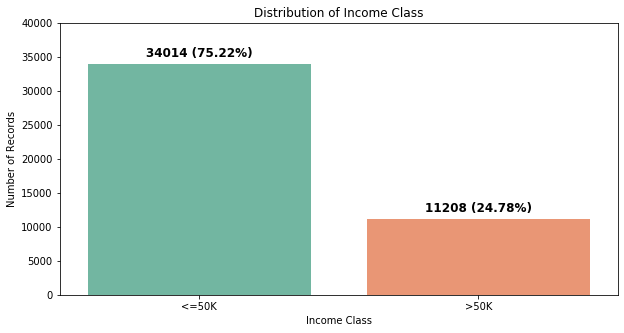

In [7]:
plt.figure(figsize=[10, 5])

fig = sns.countplot(data=df_train, x="income")

plt.title("Distribution of Income Class")
plt.xlabel("Income Class")
plt.ylabel("Number of Records")
plt.ylim(0, 40000)

income_means = df_train[df_train.income == '<=50K'].shape[0] / df_train.shape[0], df_train[df_train.income == '>50K'].shape[0] / df_train.shape[0]
i = 0

for bar in fig.patches:
    fig.annotate("{} ({:.2f}%)".format(bar.get_height(), 100 * income_means[i]), 
                 (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                 ha='center', 
                 va='center',
                 xytext=(0, 10),
                 textcoords = 'offset points',
                 fontsize=12,
                 fontweight='bold')
    i += 1

In [8]:
# Number of records where individual's income is more than $50,000
n_greater_50k = df_train[df_train['income'] == '>50K'].shape[0]

# Number of records where individual's income is at most $50,000
n_at_most_50k = df_train[df_train['income'] == '<=50K'].shape[0]

# Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k / n_records) * 100

print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


Looking at the distribution of classes (those who make at most `$50,000`, and those who make more), it's clear most individuals do not make more than `$50,000`. This can greatly affect accuracy, since we could simply say "this person does not make more than `$50,000`" and generally be right, without ever looking at the data! Making such a statement would be called naive, since we have not considered any information to substantiate the claim.

We need to convert the target `income` to numerical values. Since there are only two possible categories for the target (`<=50K` and `>50K`), we can simply encode these two categories as 0 and 1, respectively.

In [9]:
# Encode the 'income' data to numerical values
df_train.income = df_train.income.replace(to_replace=['<=50K', '>50K'], value=[0, 1])

### Early Data Analysis

Now it's time to take a closer look in the distributions and correlations with the target for each feature. This is a good place to make questions/hypotheses about the problem and use visualizations to answer it.

#### Question 1: People with a higher education are more likely to have a bigger annually income?

The `education_level` is categorical and has a notion of ranked associated. For example, we can think that bachelors, masters and doctors are more likely to have a bigger annually income than people that didn't make through collage. Is this hypotheses true?

Another variable that we can look for answers is the `education-num` that represents the total education years completed by someone. If we group by `education_level` or `education-num` and calculate the average of each income class we will see that for every value in education_level we have a equivalent value in `education-num`.

In [10]:
# get the education_level indexes by income average
educ_levels = df_train.groupby('education_level')['education-num'].mean().sort_values(ascending=False).index.tolist()

# grouping by education-num and calculating the income average
df_temp = df_train.groupby('education-num').income.mean().sort_index(ascending=False)

# get education-num indexes
educ_nums = df_temp.index

# get income average
income_means = df_temp.values

# creating a dataframe
df_temp = pd.DataFrame({'education_level': educ_levels, 'education-num': educ_nums, 'income average': income_means})

# sorting by education-num
df_temp = df_temp.sort_values('education-num', ascending=False)
df_temp

,education_level,education-num,income average
0,Doctorate,16.0,0.733456
1,Prof-school,15.0,0.754140
2,Masters,14.0,0.554097
3,Bachelors,13.0,0.419815
4,Assoc-acdm,12.0,0.264101
5,Assoc-voc,11.0,0.257274
6,Some-college,10.0,0.201030
7,HS-grad,9.0,0.163431
8,12th,8.0,0.074523
9,11th,7.0,0.054972


The `education-num` works the same way as a numeric ranked transformation applied to the values of education_level. Putting in a bar chart we obtain the following:

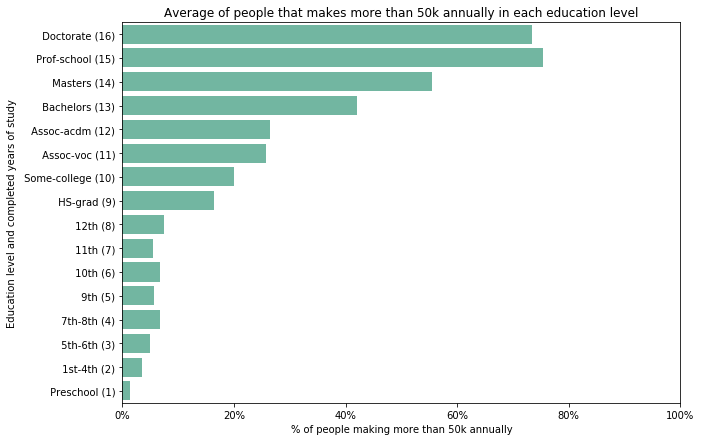

In [11]:
plt.figure(figsize=[10, 7])

# formating labels
labels = ["{} ({})".format(level, int(num)) for level, num in zip(df_temp['education_level'].values, df_temp['education-num'].values)]

sns.barplot(data=df_temp, x='income average', y='education_level', color=sns.color_palette()[0])

plt.ylabel('Education level and completed years of study')
plt.xlabel('% of people making more than 50k annually')
plt.title('Average of people that makes more than 50k annually in each education level')

plt.xlim(0, 1)
plt.yticks(np.arange(0, 16, 1), labels)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ["0%", "20%", "40%", "60%", "80%", "100%"]);

Our hypothesis is almost totally true, it has just a few wrong ranked `education-level`, perhaps because of some data noise. Notice that the elementary school years rank order are a little messy and `Prof-school` has a higher average of `income` class `>50K` but is a lower level than `Doctorate`.

#### Question 2: People that works more hours per week are more likely to have a bigger annually income?

In our data set we have the hours-per-week feature that represents how many hours each Census participant works per week and we can use this variable to answer our question.

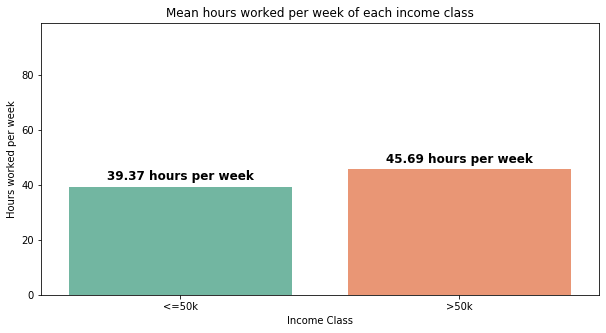

In [12]:
plt.figure(figsize=[10, 5])

fig = sns.barplot(data=df_train.groupby('income')['hours-per-week'].mean().reset_index(), x="income", y="hours-per-week")

plt.title("Mean hours worked per week of each income class")
plt.xlabel("Income Class")
plt.ylabel("Hours worked per week")
plt.ylim(0, df_train['hours-per-week'].max())


plt.xticks([0, 1], ["<=50k", ">50k"])

for bar in fig.patches:
    fig.annotate("{:.2f} hours per week".format(bar.get_height()), 
                 (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                 ha='center', 
                 va='center',
                 xytext=(0, 10),
                 textcoords = 'offset points',
                 fontsize=12,
                 fontweight='bold')

At first sight, looking at the mean of each `income` class, it appears that people in ">50k" group in fact works more hours per week than the other group. Diving a little deep, the image below shows the average of people that makes more than 50k annually distributed by hours worked per week.


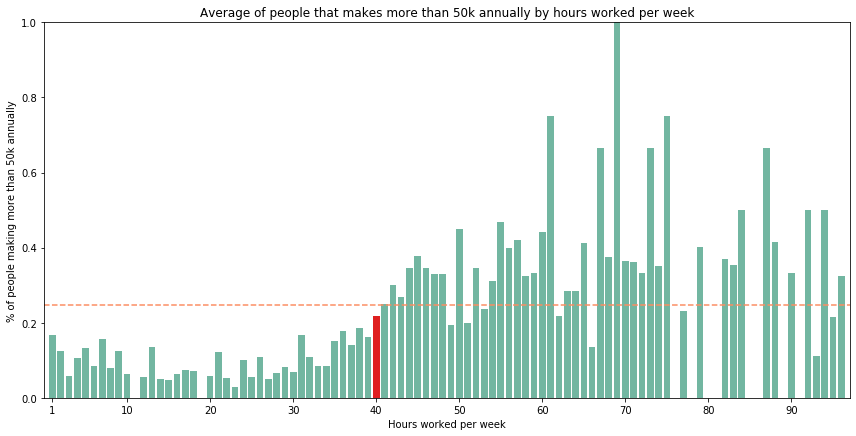

In [13]:
plt.figure(figsize=[12, 6])

income_by_hours = df_train.groupby('hours-per-week').income.mean().reset_index()
income_by_hours['hours-per-week'] = income_by_hours['hours-per-week'].astype(int)

ax = sns.barplot(data=income_by_hours, x='hours-per-week', y="income", palette=[sns.color_palette()[0] if x != 39 else 'red' for x in np.arange(0, 99, 1)],)
plt.errorbar(y=df_train.income.mean(), x=np.arange(-1, 97, 1), linestyle="--", color=sns.color_palette()[1])

ax.margins(0)

plt.tight_layout()
plt.xticks([0, 9, 19, 29, 39, 49, 59, 69, 79, 89], [1, 10, 20, 30, 40, 50, 60, 70, 80, 90])
plt.xlabel('Hours worked per week')
plt.ylabel('% of people making more than 50k annually')
plt.title('Average of people that makes more than 50k annually by hours worked per week');

The orange line shows the mean worked hours in the entire dataset. The average increases after forty hours worked per week (red bar). We have a few hours without bar because we don't have reports with to those. 

#### How experience is related in earning more than $50,000 annually?

We don't know how many years each person has worked, but the older a person is, the more years of work and life experience they usually have. Let's see if age tell us something.

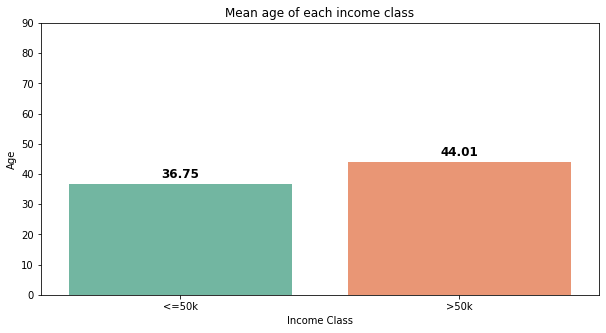

In [14]:
plt.figure(figsize=[10, 5])

fig = sns.barplot(data=df_train.groupby('income')['age'].mean().reset_index(), x="income", y="age")

plt.title("Mean age of each income class")
plt.xlabel("Income Class")
plt.ylabel("Age")
plt.ylim(0, df_train['age'].max())


plt.xticks([0, 1], ["<=50k", ">50k"])

for bar in fig.patches:
    fig.annotate("{:.2f}".format(bar.get_height()), 
                 (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                 ha='center', 
                 va='center',
                 xytext=(0, 10),
                 textcoords = 'offset points',
                 fontsize=12,
                 fontweight='bold')

Looking at the mean age of each income class, it appears that people in >50K group are in average older than the other group. Let's look at the age distribution of each income class.

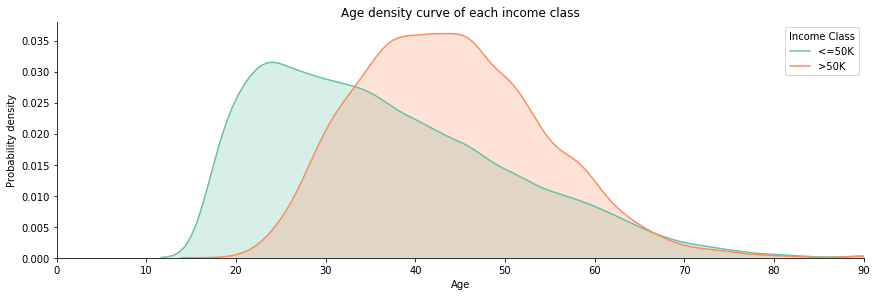

In [15]:
fig = sns.FacetGrid(df_train, hue='income', height=4, aspect=3)
fig.map(sns.kdeplot, 'age', shade=True)

fig.set(xlim=(0, df_train['age'].max()))

plt.title('Age density curve of each income class')
plt.xlabel('Age')
plt.ylabel('Probability density')
plt.legend(title='Income Class', labels=['<=50K', '>50K'])

## Preparing the Data

Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as preprocessing. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Checking for missing values

In [16]:
print('Training set')
df_train.isna().sum()

Training set


age                0
workclass          0
education_level    0
education-num      0
marital-status     0
occupation         0
relationship       0
race               0
sex                0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

In [17]:
print('Testing set')
df_test.isna().sum()

Testing set


Unnamed: 0          0
age                17
workclass          22
education_level    20
education-num      14
marital-status     21
occupation         22
relationship       16
race               19
sex                19
capital-gain       15
capital-loss       17
hours-per-week     13
native-country     16
dtype: int64

The test set has some missing values and a unnamed column. We'll fix these missing values as we go to each feature. For now, let's drop this unnamed column.

In [18]:
df_test.drop('Unnamed: 0', axis=1, inplace=True)

### Transforming Skewed Continuous Features

A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number. Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: capital-gain and capital-loss.

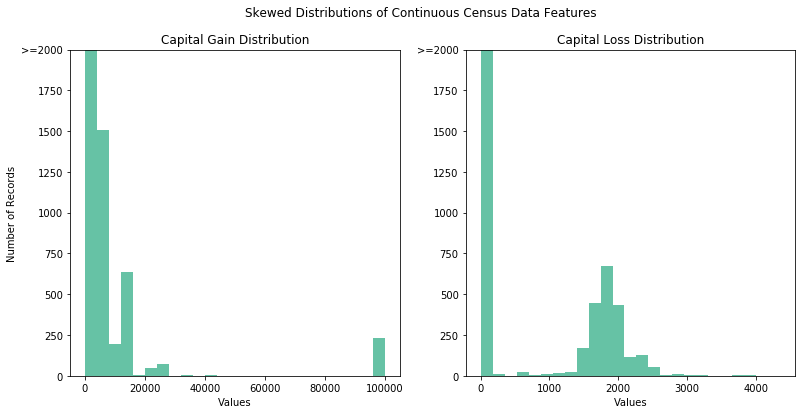

In [19]:
plt.figure(figsize = [13, 6])
base_color = sns.color_palette()[0]

labels = [0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
labels_names = ['0', '250', '500', '750', '1000', '1250', '1500', '1750', '>=2000']

plt.subplot(1, 2, 1)
plt.hist(data=df_train, x='capital-gain', bins=25)
plt.ylim(0, 2000)
plt.ylabel('Number of Records')
plt.xlabel('Values')
plt.title('Capital Gain Distribution')
plt.yticks(labels, labels_names)

plt.subplot(1, 2, 2)
plt.hist(data=df_train, x='capital-loss', bins=25)
plt.ylim(0, 2000)
plt.xlabel('Values')
plt.title('Capital Loss Distribution')
plt.yticks(labels, labels_names)

plt.suptitle('Skewed Distributions of Continuous Census Data Features');

For highly-skewed feature distributions like these, it is common practice to apply a logarithmic transformation on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of 0 is undefined, so we must translate the values by a small amount above 0 to apply the the logarithm successfully.

In [20]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']

for df in data:
    df[skewed] = df[skewed].apply(lambda x: np.log(x + 1))

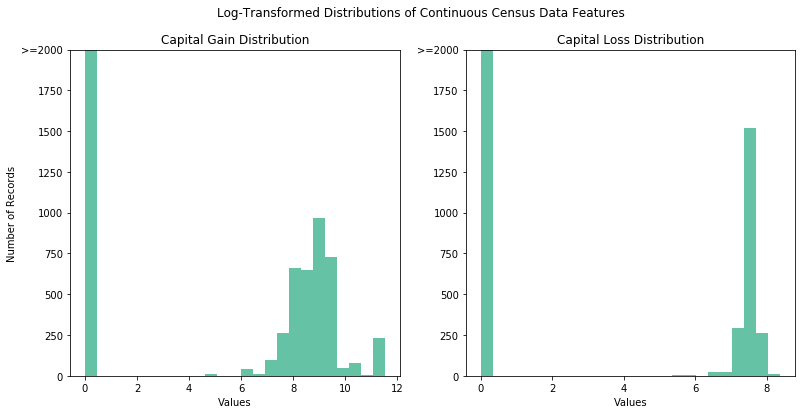

In [21]:
plt.figure(figsize = [13, 6])
base_color = sns.color_palette()[0]

labels = [0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]
labels_names = ['0', '250', '500', '750', '1000', '1250', '1500', '1750', '>=2000']

plt.subplot(1, 2, 1)
plt.hist(data=df_train, x='capital-gain', bins=25)
plt.ylim(0, 2000)
plt.ylabel('Number of Records')
plt.xlabel('Values')
plt.title('Capital Gain Distribution')
plt.yticks(labels, labels_names)

plt.subplot(1, 2, 2)
plt.hist(data=df_train, x='capital-loss', bins=25)
plt.ylim(0, 2000)
plt.xlabel('Values')
plt.title('Capital Loss Distribution')
plt.yticks(labels, labels_names)

plt.suptitle('Log-Transformed Distributions of Continuous Census Data Features');

### Normalizing Numerical Features

In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [ ]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

df_train[numerical] = scaler.fit_transform(df_train[numerical])
df_test[numerical] = scaler.transform(df_test[numerical])

In [23]:
df_train[numerical].describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,0.295177,0.607897,0.064342,0.042423,0.407531
std,0.181067,0.170192,0.214240,0.190454,0.122526
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.150685,0.533333,0.000000,0.000000,0.397959
50%,0.273973,0.600000,0.000000,0.000000,0.397959
75%,0.410959,0.800000,0.000000,0.000000,0.448980
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
df_test[numerical].describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45205.000000,45208.000000,45207.000000,45205.000000,45209.000000
mean,0.295205,0.607901,0.064341,0.042420,0.407544
std,0.181077,0.170187,0.214227,0.190448,0.122525
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.150685,0.533333,0.000000,0.000000,0.397959
50%,0.273973,0.600000,0.000000,0.000000,0.397959
75%,0.410959,0.800000,0.000000,0.000000,0.448980
max,1.000000,1.000000,1.000000,1.000000,1.000000


### Dropping Unused Feature

In [26]:
for df in data:
    df.drop('education_level', axis=1, inplace=True)

### Treating missing values

In [28]:
df_test[numerical] = df_test[numerical].transform(lambda x: x.fillna(x.mean()))

categorical=['workclass', 'marital-status', 'occupation', 'relationship', 'sex', 'race', 'native-country']
for cat in categorical:
    df_test[cat].fillna(df_test[cat].mode()[0], inplace=True)

print('Testing set')
df_test.isna().sum()

Testing set


age               0
workclass         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
dtype: int64

### Sex

In [29]:
for df in data:
    df.sex = df.sex.replace(to_replace=['Male', 'Female'], value=[1, 0])

### One Hot Encoding

Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (categorical variables) be converted. One popular way to convert these variables is by using the one-hot encoding scheme. One-hot encoding creates a "dummy" variable for each possible category variable. For example, assume `someFeature` has three possible entries: A, B, or C. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                        | someFeature_A | someFeature_B | someFeature_C |
|---|-------------|------------------------|---------------|---------------|---------------|
| 0 |      B      |                        |       0       |       1       |       0       |
| 1 |      C      | --> one-hot encode --> |       0       |       0       |       1       |
| 2 |      A      |                        |       1       |       0       |       0       |

In [30]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
df_train = pd.get_dummies(data=df_train)
df_test = pd.get_dummies(data=df_test)

# Print the number of features after one-hot encoding
encoded = list(df_train.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

88 total features after one-hot encoding.


### Splitting Data in Training and Validation

Now that all categorical variables have been converted into numerical features and normalized, we're going to split our `data` into two sets: training and validation. We can't use the same data to train and validate our model because it will learn noise from the data and loose it's ability to generalize well. That's why this step is so important.  
You can learn more about bias and variance [here](https://medium.com/@mp32445/understanding-bias-variance-tradeoff-ca59a22e2a83).

In [31]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_train.drop('income', axis=1), 
                                                    df_train.income, 
                                                    test_size = 0.3, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 31655 samples.
Testing set has 13567 samples.


## Data Modeling

In this section, we will investigate a couple different algorithms and determine which is best at modeling the data. For now, we'll use accuracy and cross validation with `k_fold = 5`.

You can learn more about cross validation [here](https://towardsdatascience.com/cross-validation-explained-evaluating-estimator-performance-e51e5430ff85).

### Models Exploration

In [77]:
MODELS = [
    #Ensemble Methods
    GradientBoostingClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    
    #GLM
    RidgeClassifierCV(),
    
    #Navies Bayes
    GaussianNB(),
    
    #Nearest Neighbor
    KNeighborsClassifier(),
    
    #Discriminant Analysis
    LinearDiscriminantAnalysis(),

    #xgboost
    XGBClassifier(random_state=42)    
]

columns = ['Model Name', 'Train AUC Mean', 'Test AUC Mean', 'Test AUC STD * 3', 'Time']
models = pd.DataFrame(columns=columns)

row_index = 0
for ml in MODELS:
    model_name = ml.__class__.__name__
    models.loc[row_index, 'Model Name'] = model_name
    
    cv_results = cross_validate(ml, df_train.drop('income', axis=1), df_train.income, scoring=make_scorer(roc_auc_score), cv=5, return_train_score=True, return_estimator=True)
    
    models.loc[row_index, 'Time'] = cv_results['fit_time'].mean()
    models.loc[row_index, 'Train AUC Mean'] = cv_results['train_score'].mean()
    models.loc[row_index, 'Test AUC Mean'] = cv_results['test_score'].mean()
    models.loc[row_index, 'Test AUC STD * 3'] = cv_results['test_score'].std() * 3
    
    row_index+=1

models.sort_values(by=['Test AUC Mean'], ascending=False, inplace=True)
models.reset_index(drop=True, inplace=True)
models

,Model Name,Train AUC Mean,Test AUC Mean,Test AUC STD * 3,Time
0,XGBClassifier,0.823325,0.79794,0.00424863,6.40557
1,GradientBoostingClassifier,0.780767,0.777137,0.0111943,5.23868
2,RandomForestClassifier,0.958967,0.770887,0.0203919,4.19106
3,LinearDiscriminantAnalysis,0.76119,0.759162,0.0086298,0.451659
4,KNeighborsClassifier,0.813251,0.748095,0.0115946,1.17576
5,RidgeClassifierCV,0.7442,0.742951,0.00547409,0.264202
6,GaussianNB,0.713856,0.712713,0.0585723,0.0483061


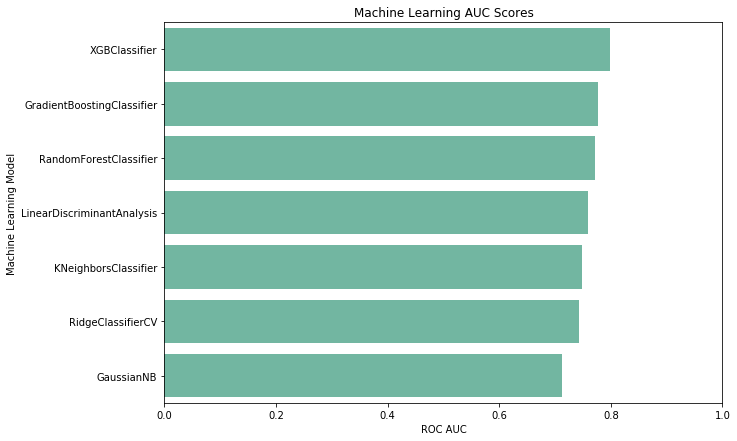

In [83]:
plt.figure(figsize=[10, 7])

sns.barplot(x='Test AUC Mean', y='Model Name', data=models, color=sns.color_palette()[0])

plt.title('Machine Learning AUC Scores')
plt.xlabel('ROC AUC')
plt.ylabel('Machine Learning Model')

plt.xlim(0, 1);

* **Random Forest** has the best score in the training set, but it's clearly over fitting.
* **XGBoost** has the best score in the validation set and the lowest standard deviation across folds.
* **Ridge** and **Linear Discriminant Analysis** are the fastest models to train and have good overall performances.
* **GaussianNB** has the lowest performance, but it's always important to consider a naive prediction as benchmark for whether a model is performing well. 

With that in mind, we'll choose the **XGBoost** as best model for this problem and perform a few further investigations.

> If our dataset was bigger and time to train was important, we could use **Rigde** or **Linear Discriminant Analysis**.

### Feature Importances

Like the weights in a regression, machine learning models based on decision trees has a nice way to see the how important each feature is in predicting the results. Usually we can access these "weights" in `model.feature_importances_`. We can plot the feature importances with accumulative.

In [57]:
importances = []
for i in range(10):
    rf = XGBClassifier()
    rf.fit(df_train.drop('income', axis=1), df_train.income)
    if len(importances) > 0:
        importances = [x + y for x, y in zip(importances, rf.feature_importances_)]
    else:
        importances = rf.feature_importances_

importances = [x / 10 for x in importances]
importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
importances.sort_values('importance', ascending=False, inplace=True)

acc = []
for i in importances.importance.values:
    acc.append(i + acc[-1] if len(acc) > 0 else i)
importances['acc'] = acc

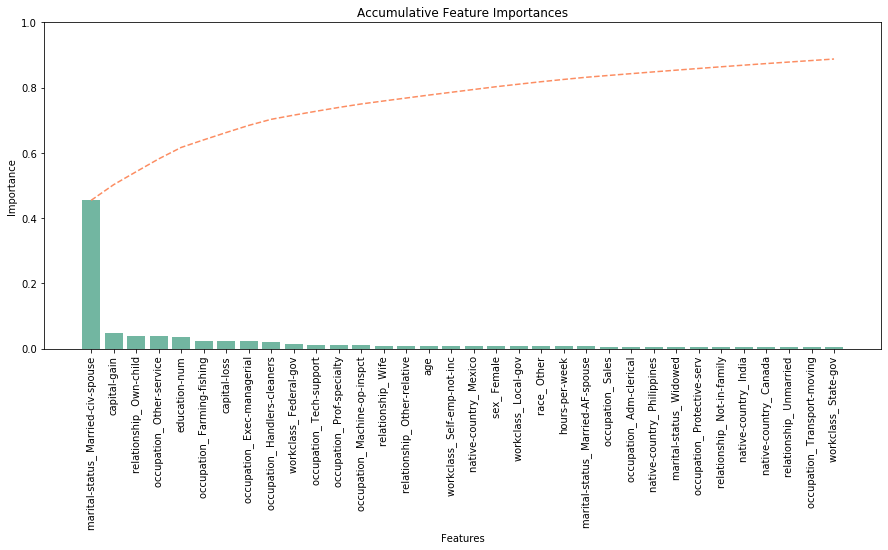

In [58]:
plt.figure(figsize=[15, 6])

sns.barplot(data=importances.loc[:10, :], x='feature', y='importance', color=sns.color_palette()[0])
plt.plot(importances.loc[:10, 'feature'], importances.loc[:10, 'acc'], '--', color=sns.color_palette()[1])
plt.ylabel('Importance')
plt.xlabel('Features')
plt.title('Accumulative Feature Importances')
plt.xticks(rotation=90)
plt.ylim(0, 1)

plt.show()

The `marital-status` for `Married-civ-spouse` has the bigger importance for the model.

Reading the XGBoost documentation, there are three main different types of how the importance can be calculated and here we used the weight type, that is the number of times a feature appears in a tree. You can read about the other ones [here](https://xgboost.readthedocs.io/en/latest/python/python_api.html).

## Evaluating the Results

CharityML is interested in predicting who makes more than `$50,000` accurately. It would seem that using accuracy as a metric for evaluating a particular model's performance would be appropriate.

Additionally, identifying someone that does not make more than $50,000 as someone who does would be detrimental to CharityML, since they are looking to find individuals willing to donate.

Therefore, a model's ability to precisely predict those that make more than $50,000 is more important than the model's ability to recall those individuals. There are several metrics that could be used here, but we'll use ROC AUC because it's the metric chosen as evaluation method by Udacity in the Kaggle competition.

### Optimizing the Model

Now that we know that the competition will evaluate our model based on ROC AUC metric, we can use this as a guide to optimize the model.

Each machine learning model has a set of parameters that we can set to change the way that the models works. For example, in the XGBoost algorithm we can set the depth of each decision tree, the regularization factor in the loss function, the learning rate and several others.

With all these parameters to use, how can we know the best values to every one? We can use an approach called Grid Search. Inputting a metric and a dictionary of parameters with an possible values, the Grid Search will train a model for each combination of values and return the best model based on the metric.

In [ ]:
parameters = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}

scorer = make_scorer(roc_auc_score)
grid_obj = GridSearchCV(estimator=XGBClassifier(random_state=42), param_grid=parameters, scoring=scorer, cv=5)
grid_fit = grid_obj.fit(X_train, y_train)
best_model = grid_fit.best_estimator_

After running the Grid Search, here are the results for the unoptimized and the optimized model:

In [85]:
best_predictions = best_model.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model")
print("ROC/AUC on the testing data: {:.4f}".format(models.loc[0]['Test AUC Mean']))

print("\nOptimized Model")
print("Final ROC/AUC on the testing data: {:.4f}".format(roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])))

Unoptimized model
ROC/AUC on the testing data: 0.7979

Optimized Model
Final ROC/AUC on the testing data: 0.9273


Maybe you might think the improvement is minimal, but 1% in every metric without spending a lot of time in the Data Preparation step, it's a great result.

## Deploying

One approach to deploy this model could be making it available through an API Endpoint. Now, we just have to send the information of a new person and the model will predict to each income class it belongs. The CharityML can use this information to send a letter or not.

As I said before, the Udacity created a ongoing Kaggle private competition. Students can send their models and see how well it performs against the models from others students worldwide.

In [ ]:
best_model

In [68]:
model = XGBClassifier(random_state=42)
model.fit(df_train.drop('income', axis=1), df_train.income)
# Make predictions using the unoptimized and model
predictions = model.predict(X_test)

In [70]:
df_submission = pd.read_csv('data/test_census.csv')
df_submission.rename(columns={"Unnamed: 0": "id"}, inplace=True)

In [71]:
final_pred = model.predict_proba(df_test)[:, 1]

In [72]:
submission_data = pd.DataFrame(df_submission["id"])
submission_data["income"] = final_pred

,id,income
0,0,0.010519
1,1,0.719503
2,2,0.135441
3,3,0.999169
4,4,0.019855


In [73]:
submission_data.to_csv("../data/submission.csv", index=False)